# Causal Data Science Week 2 Tutorial

In this toturial, you will learn:
- how to use the package networkX to design causal graphs of your own and import them into the DoWhy package;
- how to test independence and correlation on linear and non-linear data.

## 1 NetworkX

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. 

With NetworkX you can load and store networks in standard and nonstandard data formats, generate many types of random and classic networks, analyze network structure, build network models, design new network algorithms, draw networks, and much more.

Here is the documentation of how to use NetworkX: https://networkx.org/documentation/stable/reference/introduction.html.

We show a step-by-step example of creating and manipulating graphs. There are many ways of adding nodes and edges either individually and/or from a list.

We first initialize the Graph object:

In [1]:
import networkx as nx
G = nx.Graph()

We use the following function draw the Graph (which currently is empty):

NetworkXError: random_state_index is incorrect

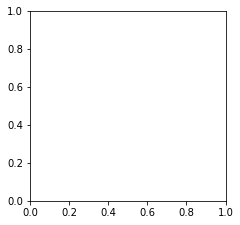

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3.5,3.5)) # change the plot size
nx.draw(G, with_labels=True, ax=ax)

We first add a node to the graph, labelled '1'

In [5]:
G.add_node(1)

and then draw the graph again:

NetworkXError: random_state_index is incorrect

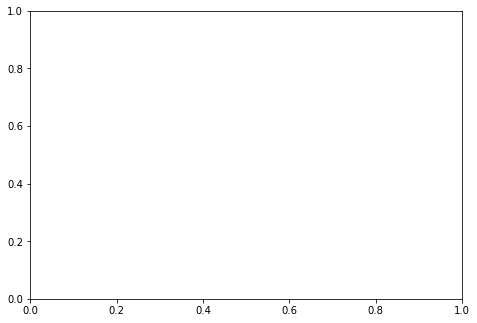

In [6]:
nx.draw(G, with_labels=True)

We can also add nodes from a list.

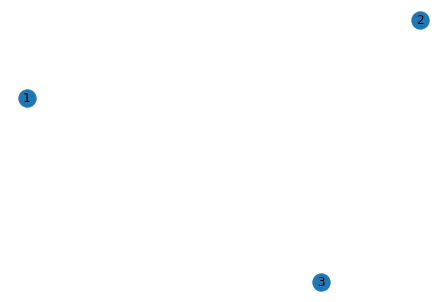

In [35]:
G.add_nodes_from([2, 3])
nx.draw(G, with_labels=True)

Next, we add an edge between node 1 and node 2.

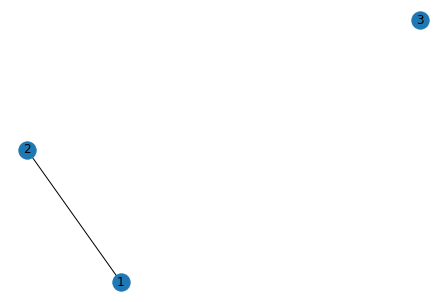

In [36]:
# then we add edges
G.add_edge(1, 2)
nx.draw(G, with_labels=True)

Finally we add an edge from node 2 to node 3.

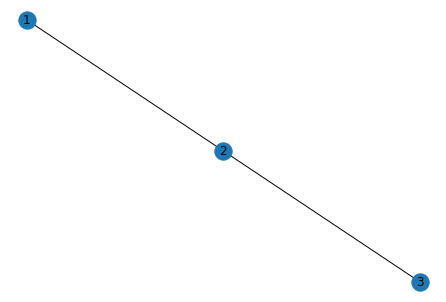

In [37]:
e = (2, 3)
G.add_edge(*e)  # unpack edge tuple*
nx.draw(G, with_labels=True)

We can check the current number of nodes and edges in the graph by calling:

In [38]:
print("Current number of nodes in the graph is ", G.number_of_nodes())
print("Current number of edges in the graph is ", G.number_of_edges())

Current number of nodes in the graph is  3
Current number of edges in the graph is  2


NetworkX is not primarily a graph drawing package but basic drawing with Matplotlib as well as an interface to use the open source Graphviz software package are included. These are part of the networkx.drawing module and will be imported if possible.


One use case of NetworkX is to design the causal graphs that we assumed and export them to .dot file or .gml file so that we can load into DoWhy package for further estimation.

We can export the graph we draw to a .gml file named 'networkx' by using the following commands.

In [39]:
nx.write_gml(G, "networkx.gml")

We can also read .gml file and parse it to a Graph object in NetworkX.

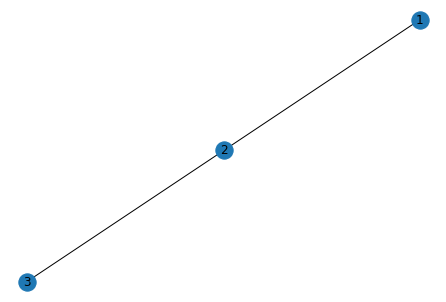

In [40]:
H = nx.read_gml("networkx.gml")
nx.draw(H, with_labels=True)

We can also read the .gml file and parse it to string using the utility function below. This is the format the graph needs to be provided in to DoWhy.

In [41]:
# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

In [42]:
print(gml_to_string("networkx.gml"))

graph [  node [    id 0    label "1"  ]  node [    id 1    label "2"  ]  node [    id 2    label "3"  ]  edge [    source 0    target 1  ]  edge [    source 1    target 2  ]]


## 2 Confounding Example: Finding causal effects from observed data using assumed causal graph

Suppose you are given some data with treatment, outcome and common cause. Can you estimate the causal effect with the knowledge of the causal graph?

With this example you will learn how to use the causal graph based on your own knowledge and estimate the causal effects with it.

In [3]:
# we first load useful modules for the example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

# the code below simple hides some warnings we don't want to see
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

### Synthetic data creation

For the convience of data manipulation, we create a synthetic dataset that is generated from the model: Treatment cause outcome. In this case, we have prior knowledge about the causal graph.

We can create and view the dataset as follows.

In [4]:
# we assume the effect of treatment for outcome is 1
effect = 1

data_dict = dowhy.datasets.xy_dataset(10000, effect=effect,
                                      num_common_causes=1,
                                      sd_error=0.2)
df = data_dict['df']
print(df[["Treatment", "Outcome", "w0"]].head())

   Treatment    Outcome        w0
0   9.758723  19.790875  3.863980
1   4.333740   9.280870 -1.344714
2   2.073248   3.980777 -3.997226
3   9.297672  18.163684  3.164543
4   9.243905  18.441882  3.189757


We can also plot the treatment and outcome.

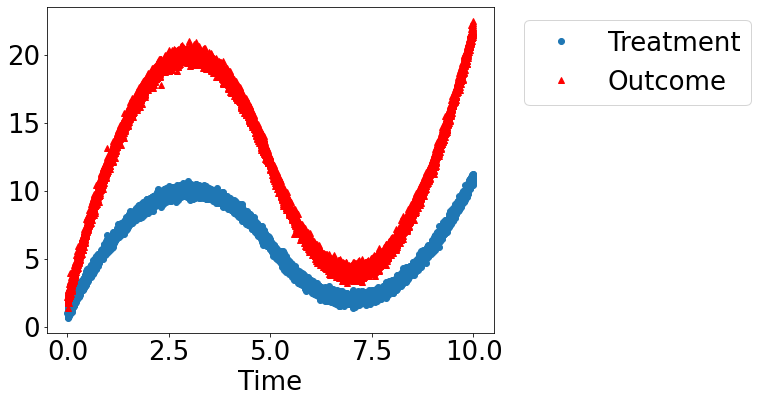

In [5]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]], 
                                     df[data_dict["time_val"]])

We follow the 4 steps that we introduced from week 1's tutorial to estimate the causal effect.

### STEP 1: Model the problem as a causal graph

In this example we show the way to load the assumed causal graph. We first draw a causal graph with NetworkX and then export to a .gml file that can be loaded later for the causal model. It is recommended to use .gml format with the DoWhy package.

NetworkXError: random_state_index is incorrect

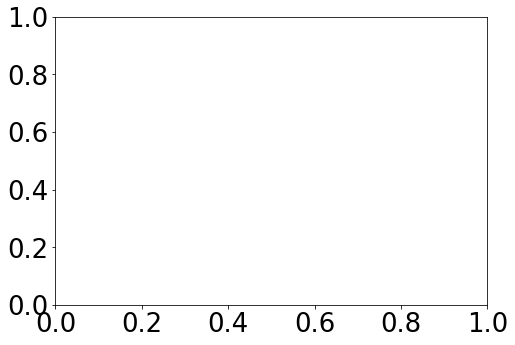

In [6]:
G = nx.DiGraph() # DiGraph creates a directed graph, which is what we need for causal graphs

G.add_nodes_from(['Treatment', 'Outcome', 'w0'])
G.add_edges_from([('Treatment', 'Outcome'), ('w0', 'Treatment'), ('w0', 'Outcome')])

nx.draw(G, with_labels=True)

nx.write_gml(G, "test.gml")

While creating the causal model, we load the gml string we created and display it with the internal interface in DoWhy.

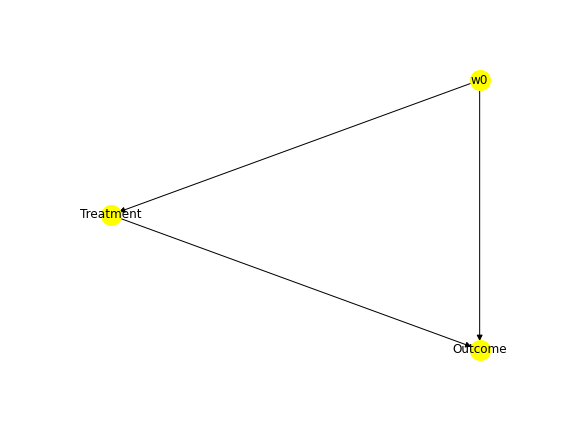

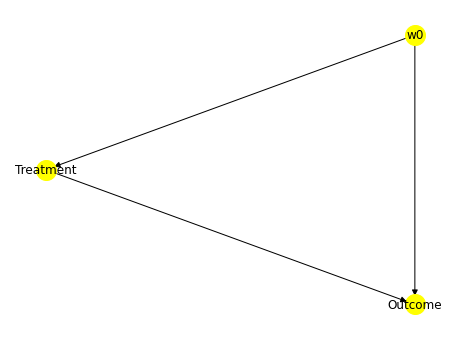

In [47]:
from IPython.display import Image, display

gml_graph = gml_to_string('test.gml')
# With GML string
model=CausalModel(
        data = df,
        treatment='Treatment',
        outcome='Outcome',
        graph=gml_graph
        )
model.view_model()

display(Image(filename="causal_model.png", width = 200, height = 100))

### STEP 2: Identify causal effect using properties of the formal causal graph


In [48]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(Expectation(Outcome|w0))
d[Treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### STEP 3: Estimate the causal effect

Causal Estimate is 0.9933671498528769


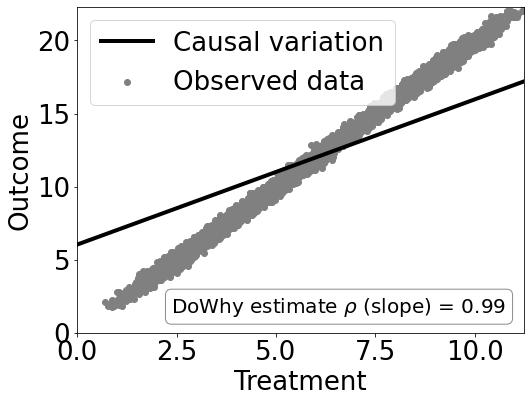

In [49]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

We can also get confidence intervals of the obtained estimate with bootstrapping.

In [50]:
estimate.get_confidence_intervals()

array([[0.97366783, 1.01306647]])

Then check if the estimate is correct by comparing with the true effect that we used for creating the synthetic dataset.

In [51]:
print("DoWhy estimate is " + str(estimate.value))
print ("Actual true causal effect was {0}".format(effect))

DoWhy estimate is 0.9933671498528769
Actual true causal effect was 1


### STEP 4: Refuting the estimate

Replacing treatment with a random (placebo) variable.

In [52]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.9933671498528769
New effect:-2.735105165072582e-06
p value:0.47



Removing a random subset of the data.

In [53]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:0.9933671498528769
New effect:0.9931081425891248
p value:0.42000000000000004



## 3 Independence tests

In the lecture, we saw the definition of correlation and dependence. Here, we will look at generating data and doing independence tests.

In [ ]:
# WARNING:
# The installation takes a few minutes.
# Only run during the first time running this notebook and if you don't have these packages installed. 
# Run in terminal command line instead if it does not work.

# !pip install hyppo
# !pip install pingouin
# !pip install conditional_independence

### 3.A Data with marginal distribution

We first do correlation and independence tests on data considering only the marginal distributions.

### Linearly dependent data

First, we generate data samples of two variables that have strong positive correlations. The first variable will be random numbers drawn from a Gaussian distribution with a mean of 100 and a standard deviation of 20. The second variable will be values from the first variable multiplied by 2.

data1: mean=100.776 stdv=19.620
data2: mean=201.552 stdv=39.240


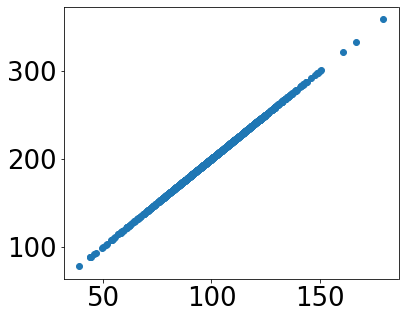

In [54]:
# generate related variables
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot
# seed random number generator
seed(1)
# prepare data
data1 = 20 * randn(1000) + 100
data2 = data1 * 2
# summarize
print('data1: mean=%.3f stdv=%.3f' % (mean(data1), std(data1)))
print('data2: mean=%.3f stdv=%.3f' % (mean(data2), std(data2)))
# plot
fig, ax = plt.subplots(figsize=(6,5))
pyplot.scatter(data1, data2)
pyplot.show()

Because of our manipulation, we know there is correlaiton in the data samples. From the scatter plot, we can see the increasing trend of the data.
To calculate the correlation between these two variables, we use Pearson's correlation which is the default measurement in the numpy package for the function `numpy.corrcoef()`. The Peason's correlation is calculated as follows:


<center>Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))</center>

See more details of implementation are available at: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

In [55]:
# calculate the Pearson's correlation between two variables
import numpy as np
# calculate Pearson's correlation
corr = np.corrcoef(data1, data2)[0,1]
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 1.000


The results indicate a perfect positive correlation between the two variables, as we would expect.

### Uncorrelated but dependent data

From the lecture we also saw examples of uncorrelated but dependent data. We will demonstrate such data here. 

We generate 10000 data samples of two variables, $x$ and $y$. $x$ is drawn from a Gaussian distribution with a mean of 0 and a standard deviation of 2 and $y$ is the cosine of $x$ with Gaussian noise added with a mean of 0 and a standard deviation of 0.5.

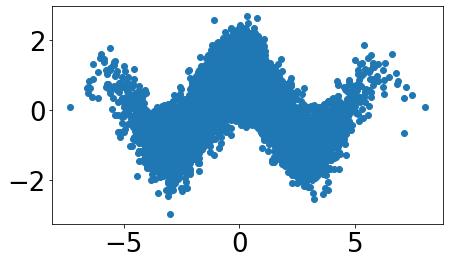

CorrCoef:  0.002513542838384999


In [56]:
import matplotlib.pyplot as plt
N_SAMPLES = 10000

def genSamples(n):

    x = np.random.normal(0,2,size=(n))
    y = np.cos(x)+np.random.normal(0,0.5, n)

    return x,y

x,y = genSamples(N_SAMPLES)

fig, ax = plt.subplots(figsize=(7, 4))
plt.scatter(x,y)
plt.show()

print ("CorrCoef: ", np.corrcoef(x,y)[0,1])

From the scatter plot we can see that two variables are uncorrelated because as one variable increases the other one does not increase or decrease. However, from the way we generate the data samples, we know that $y$ is a function of $x$ and they are dependent. 

Thus, when two variables are independent, the correlation coefficient is zero. However, the inverse is not true. 

### Non-parametric test
Now, we use Hilbert Schmidt Independence Criterion (Hsic) to test the dependence of the data above.

Hsic is a kernel based independence test and is a way to measure multivariate nonlinear associations given a specified kernel [1].

[1] Arthur Gretton, Kenji Fukumizu, Choon Teo, Le Song, Bernhard Schölkopf, and Alex Smola. A Kernel Statistical Test of Independence. Advances in Neural Information Processing Systems, 2007.
https://proceedings.neurips.cc/paper/2007/file/d5cfead94f5350c12c322b5b664544c1-Paper.pdf

In [57]:
from hyppo.independence import Hsic

c_h = Hsic().test(x, y)
print(c_h)

IndependenceTestOutput(stat=0.2796786220993399, pvalue=0.0)


The significant p-value tells us that these two variables are not independent, so the test confirms what we already know.

### 3.B Data with conditional distribution

We then do correlation and independence tests on data with conditional distribution.

### Partial correlation with data

We use pingouin package to generate data with confoundings and then measure the partial correlation between two variables when conditioning on different covariates.

Partial correlation measures the degree of association between x and y, after removing the effect of one or more controlling variables (covar, or 𝑍).
For more implementation details see: https://pingouin-stats.org/generated/pingouin.partial_corr.html#pingouin.partial_corr

We generate a standard random normal variable 'z', and then define 'x' and 'y' as 'z' with another standard normal random variable.

In [58]:
import pingouin as pg

z = np.random.normal(size = 500)
x = z + np.random.normal(size = 500)
y = z + np.random.normal(size = 500)
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

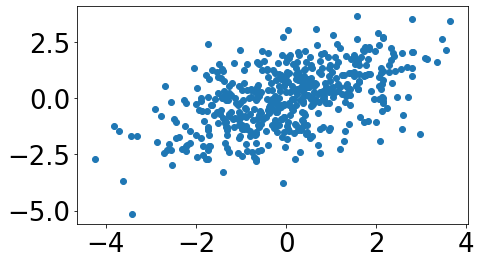

In [59]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.scatter(x, y)

We first test the correlation between x and y, and we can see that x and y are correlated to some degree.

In [60]:
pg.corr(x, y)

,n,r,CI95%,p-val,BF10,power
pearson,500,0.520047,"[0.45, 0.58]",5.439495e-36,5.148e+32,1.0


Then we test the partial correlation with conditioning on one covariate. We can see that the correlation is gone when conditioning on z.

In [61]:
pg.partial_corr(data=df, x='x', y='y', covar='z').round(5)

,n,r,CI95%,p-val
pearson,500,0.04598,"[-0.04, 0.13]",0.30531


The results indicate that correlation between variables may be solely the result of another variable(s). When we condition on different covariates, the partial correlation changes (and may even disappear), which give us useful information for modelling the data.

### Conditional independence tests with data

Finally, we would like to test the conditional independence of the data. We use the conditional version of Hsic from the package `conditional_independence`.

**Caution!** This package is not very well documented yet; however, there are a few well documented implementations in R and Matlab. Those who are comfortable with R and Matlab can check here: https://github.com/garydoranjr/kcipt/ and 
https://github.com/ericstrobl/RCIT.

We use the same dataset as before and then run the conditional independence test on them.

In [62]:
import conditional_independence.ci_tests.nonparametric.hsic as cond_hsic

res = cond_hsic.hsic_test(df.to_numpy(), 0, 1, [2])
print(res)

{'statistic': 0.0006070713907561201, 'p_value': 0.4031656785644113, 'reject': False, 'mean_approx': 0.000581990295731129, 'var_approx': 7.000971471403151e-08}


The non-significant p-value tells us that these data are independent when we condition on $z$.